## Deadend 해결
### 그냥 heuristic map을 쓰기로 하고, 그러면 직접적인 장애물에 대한 deadend는 생각하지 않아도 됨
### 그러나 목표물에 도착한 에이전트가 더이상 움직이지 않아 새로운 장애물이 된다면 heuristic map을 그 에이전트를 발견한 다른 에이전트가 업데이트하도록 해야 함
### 1단계: 한 에이전트에 대해서 navigate를 휴리스틱 맵을 쓰도록 고치기
### 2단계: 에이전트가 시야 내에서 다른 도착한 에이전트를 발견할 시 그것을 장애물로 취급하여 휴리스틱 맵을 업데이트하도록 고치기

## 1단계

In [2]:
import os
import numpy as np
from crewai import Agent, Task, Crew
from environment import Environment
from openai import OpenAI
import configs
import pickle

os.environ["OPENAI_API_KEY"] = ""
client = OpenAI()

In [3]:
#negotiator를 구성하기 위한 union find 알고리즘

def find(parent, i):
    if parent[i] == i:
        return i
    else:
        return find(parent, parent[i])

def union(parent, rank, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)

    if xroot != yroot:
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

def merge_sets(lists):
    element_to_index = {}
    for i, subset in enumerate(lists):
        for element in subset:
            element_to_index[element] = i

    parent = [i for i in range(len(lists))]
    rank = [0] * len(lists)

    for subset in lists:
        first_element = subset[0]
        for element in subset[1:]:
            union(parent, rank, find(parent, element_to_index[first_element]), find(parent, element_to_index[element]))

    new_sets = {}
    for element in element_to_index:
        root = find(parent, element_to_index[element])
        if root not in new_sets:
            new_sets[root] = set()
        new_sets[root].add(element)

    return [list(s) for s in new_sets.values()]

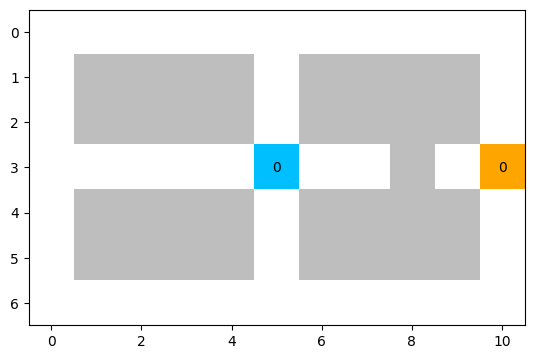

In [4]:
directiondict = {
    'Stay': 0, 'North': 1, 'South': 2, 'West': 3, 'East': 4, 'Stay.': 0, 'North.': 1, 'South.': 2, 'West.': 3, 'East.': 4 
}

# Toy example 만들기(환경, 처음 위치, 목적지)
toy = (np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), np.array([[3, 5]]), np.array([[3, 10]]))
num_agents = len(toy[1])
map_height = len(toy[0]) - 1

env = Environment()
env.load(toy[0], toy[1], toy[2])
env.render()

In [32]:
#이 부분에서 수정이 들어가면 될 것 같아요(task에서 어느 방향으로 내비게이트해야 할지에 대한 추천을 observe에서 얻은 휴리스틱 맵에서 얻는 식으로)

class PathFindingAgents:
  def path_finder(self, agent_number):
    return Agent(
      role='Path finder',
      goal='Start at the start point and reach the end point without crashing into a wall.',
      backstory=f"""You are a veteran adventurer with a great sense of direction.
      You understand which direction you need to move to get from where you are to where you want to go.
      Your agent number is {agent_number}.
      """,
      verbose=True
    )
  
class PathFindingTasks():
  def path_finding(self, agent, east, west, north, south, heuristic_direction):
    return Task(
      description=(
        f"""
        You can only move east, west, south and north or stay.
        So, your answer will be {{East}}, {{West}}, {{South}}, {{North}}, or {{Stay}}.
        You can only make one move at a time.
        {east}
        {west}
        {south}
        {north}
        Your heuristic map says going {heuristic_direction} will shorten the distance to the destination without any possibility of dead ends.
        Which direction do you move next?
        Answer in one word only: {{DIRECTION or ACTION}}
        """
      ),
      expected_output='Direction or action',
      agent=agent
    )
  
agents = PathFindingAgents()
tasks = PathFindingTasks()

agents_set = [agents.path_finder(i) for i in range(num_agents)]

In [33]:
#에이전트들의 지난번 액션들
action_list = [[] for _ in range(num_agents)]

2024-07-02 12:29:09,046 - 19828 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...
Considering the information provided and the layout of the terrain with a clear path to the east that will shorten the distance to the destination without any possibility of dead ends, the best course of action appears to be moving east.

Final Answer: East.

> Finished chain.


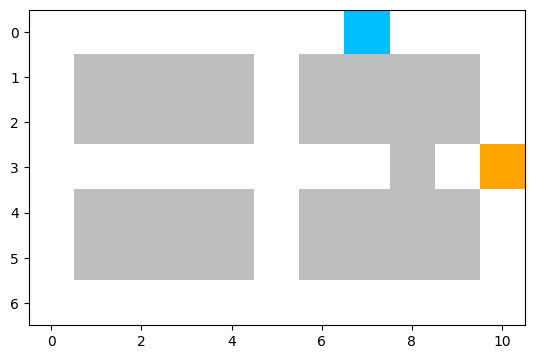

2024-07-02 12:29:13,277 - 19828 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...
Based on the given instructions and the heuristic map, the best direction to move is east as it will shorten the distance to the destination without any possibility of dead ends.

Final Answer: East

> Finished chain.


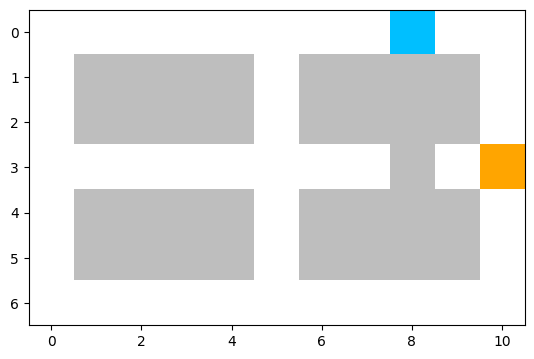

2024-07-02 12:29:16,296 - 19828 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...
Based on the information provided, moving east will shorten the distance to the destination without any possibility of dead ends. Thus, it is the most logical direction to move in.

Final Answer: East

> Finished chain.


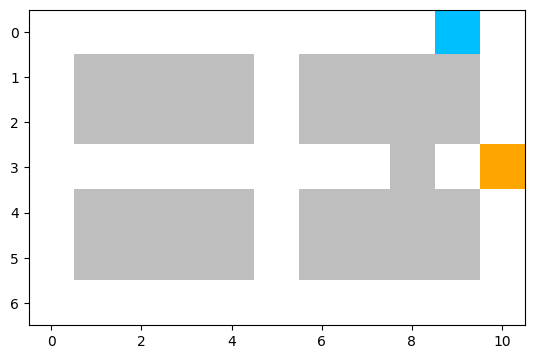

2024-07-02 12:29:18,967 - 19828 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...
After analyzing the situation and considering the heuristic map, the most logical direction appears to be east. 

Final Answer: East

> Finished chain.


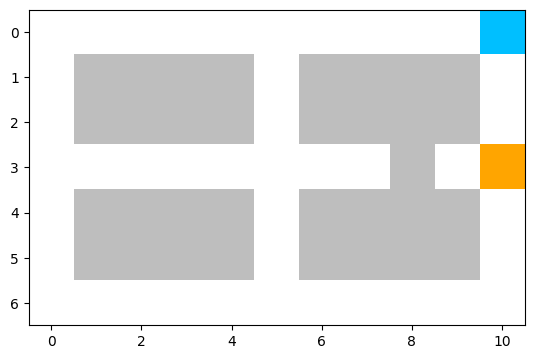

2024-07-02 12:29:21,805 - 19828 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...
Based on the information given, the most logical direction to go would be south as it is said to shorten the distance to the destination without any possibility of dead ends.

Final Answer: South

> Finished chain.


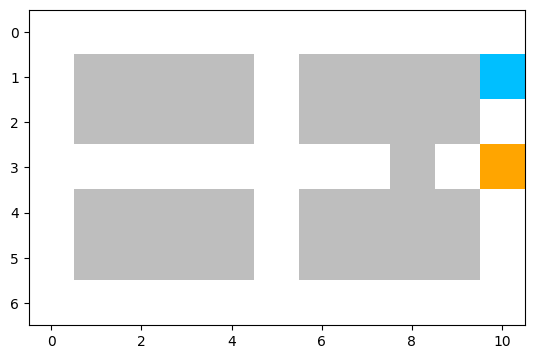

2024-07-02 12:29:24,378 - 19828 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...
Based on the information provided, the best direction to move in would be south as it shortens the distance to the destination without any chance of encountering a dead end.

Final Answer: South

> Finished chain.


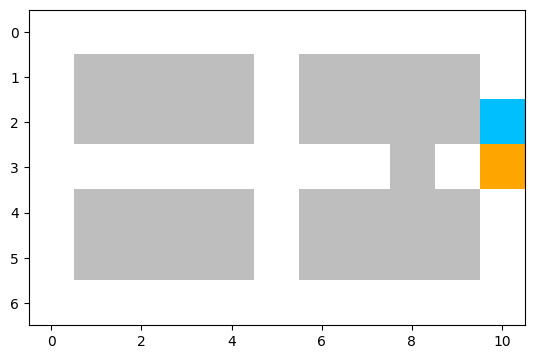

2024-07-02 12:29:27,293 - 19828 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...
Given the information provided, it's evident that moving south is the most efficient route. This is because the heuristic map indicates that going south will lessen the distance to the destination without any possibility of encountering a dead end. 

Final Answer: South

> Finished chain.


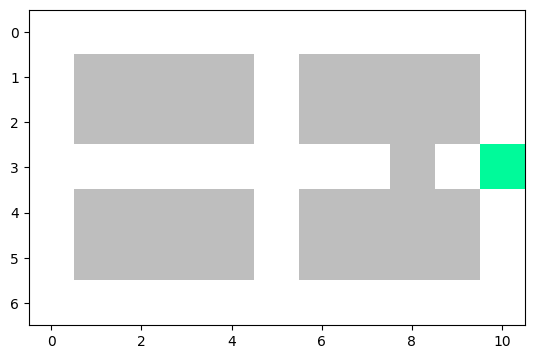

2024-07-02 12:29:30,479 - 19828 - __init__.py-__init__:518 - WARNING: Overriding of current TracerProvider is not allowed




> Entering new CrewAgentExecutor chain...
The task does not provide a specific direction that will shorten the distance to the destination without any possibility of dead ends. Therefore, it is not possible to determine the best move based on the given information. 

Final Answer: I'm sorry, but the task does not provide sufficient information to determine the best move.

> Finished chain.


KeyError: "I'm sorry, but the task does not provide sufficient information to determine the best move."

In [37]:
# 2 turn
for n in range(10):

  step = [0 for i in range(num_agents)]

  #각 에이전트들의 시야에 있는 자신과 다른 에이전트들
  FOV_agents = []
  for i in range(num_agents):
    if np.any(env.observe()[0][i][0][2:7, 2:7]):
      non_zero_elements = env.observe()[0][i][0][2:7, 2:7][env.observe()[0][i][0][2:7, 2:7] != 0].tolist()
      non_zero_elements = [element - 1 for element in non_zero_elements]
      non_zero_elements.append(i)
      FOV_agents.append(non_zero_elements)

  #알고리즘을 이용해 연결된 집합 찾기
  connected_set = merge_sets(FOV_agents)

  #연결이 있는 모든 에이전트들
  deadlocked_agents = [item for sublist in connected_set for item in sublist]

  for i in range(num_agents):

    #교착상태에 빠지지 않은 에이전트는 독립적으로 navigate
    if i not in deadlocked_agents:
      
      a_obs = env.observe()[0][i][1]

      if a_obs[4][3] == 0:
        west = """To your west lies a path."""
      else:
        west = """Your west is blocked by a wall."""

      if a_obs[4][5] == 0:
        east = """To your east lies a path."""
      else:
        east = """Your east is blocked by a wall."""

      if a_obs[5][4] == 0:
        south = """To your south lies a path."""
      else:
        south = """Your south is blocked by a wall."""

      if a_obs[3][4] == 0:
        north = """To your north lies a path."""
      else:
        north = """Your north is blocked by a wall."""

      directions = []
      if env.observe()[0][i][2][4, 4] == 1:
        directions.append('north')
      if env.observe()[0][i][3][4, 4] == 1:
        directions.append('south')
      if env.observe()[0][i][4][4, 4] == 1:
        directions.append('west')
      if env.observe()[0][i][5][4, 4] == 1:
        directions.append('east')
      
      heuristic_direction = ' and '.join(directions)

      navigation = tasks.path_finding(agents_set[i], east, west, north, south, heuristic_direction)

      crew = Crew(
        agents=[agents_set[i]],
        tasks=[navigation],
        verbose=0,
      )

      result = crew.kickoff()

      if result not in directiondict:
        result = 'stay'

      action_list[i].append(result)
    
      step[i] = directiondict[result]




  env.step(step)
  env.render()

## 2단계

In [ ]:
import os
import numpy as np
from crewai import Agent, Task, Crew
from environment import Environment
from openai import OpenAI
import configs
import pickle

os.environ["OPENAI_API_KEY"] = ""
client = OpenAI()

In [38]:
#negotiator를 구성하기 위한 union find 알고리즘

def find(parent, i):
    if parent[i] == i:
        return i
    else:
        return find(parent, parent[i])

def union(parent, rank, x, y):
    xroot = find(parent, x)
    yroot = find(parent, y)

    if xroot != yroot:
        if rank[xroot] < rank[yroot]:
            parent[xroot] = yroot
        elif rank[xroot] > rank[yroot]:
            parent[yroot] = xroot
        else:
            parent[yroot] = xroot
            rank[xroot] += 1

def merge_sets(lists):
    element_to_index = {}
    for i, subset in enumerate(lists):
        for element in subset:
            element_to_index[element] = i

    parent = [i for i in range(len(lists))]
    rank = [0] * len(lists)

    for subset in lists:
        first_element = subset[0]
        for element in subset[1:]:
            union(parent, rank, find(parent, element_to_index[first_element]), find(parent, element_to_index[element]))

    new_sets = {}
    for element in element_to_index:
        root = find(parent, element_to_index[element])
        if root not in new_sets:
            new_sets[root] = set()
        new_sets[root].add(element)

    return [list(s) for s in new_sets.values()]

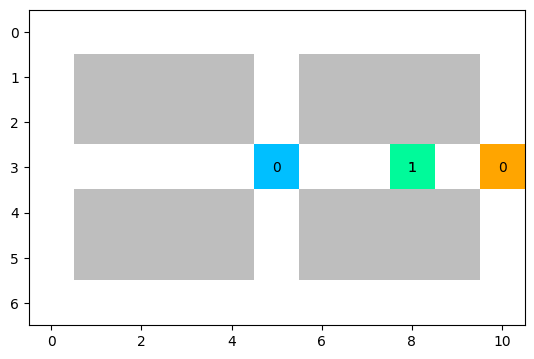

In [39]:
directiondict = {
    'Stay': 0, 'North': 1, 'South': 2, 'West': 3, 'East': 4, 'Stay.': 0, 'North.': 1, 'South.': 2, 'West.': 3, 'East.': 4 
}

# Toy example 만들기(환경, 처음 위치, 목적지)
toy = (np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), np.array([[3, 5], [3, 8]]), np.array([[3, 10], [3, 8]]))
num_agents = len(toy[1])
map_width = len(toy[0][0]) - 1

env = Environment()
env.load(toy[0], toy[1], toy[2])
env.render()

In [40]:
heuristic_map = env.heuri_map

In [48]:
heuristic_map[0, :]

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal